In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset , DataLoader, random_split
from torchvision import transforms, datasets
import torchmetrics
from torchmetrics.classification import MulticlassF1Score

In [2]:
def set_seed( seed ) :
    random.seed( seed )
    np.random.seed( seed )
    torch.manual_seed( seed )
    torch.cuda.manual_seed ( seed )
    torch.cuda.manual_seed_all ( seed )
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    seed = 59
    set_seed ( seed )

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset

In [4]:
root_dir = "/kaggle/input/aiomodule6imageweatherdataset/weather-dataset/dataset"
img_size = 128
train_percent = 0.8

transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor()
])

### Load dataset
dataset = datasets.ImageFolder(
    root = root_dir,
    transform = transform
)

### Split dataset
train_size = int(train_percent*len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size]) # return class Datasets

In [5]:
# class2id: maps class name to label index
class2id = dataset.class_to_idx

# id2class: maps label index to class name
id2class = {v: k for k, v in class2id.items()}

print("class2id:", class2id)
print("id2class:", id2class)


class2id: {'dew': 0, 'fogsmog': 1, 'frost': 2, 'glaze': 3, 'hail': 4, 'lightning': 5, 'rain': 6, 'rainbow': 7, 'rime': 8, 'sandstorm': 9, 'snow': 10}
id2class: {0: 'dew', 1: 'fogsmog', 2: 'frost', 3: 'glaze', 4: 'hail', 5: 'lightning', 6: 'rain', 7: 'rainbow', 8: 'rime', 9: 'sandstorm', 10: 'snow'}


Shape: torch.Size([3, 128, 128])
Label ID: 9
Class Name: sandstorm


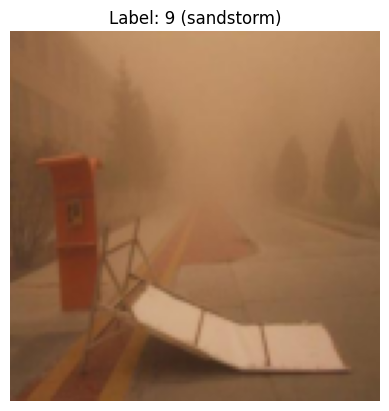

In [6]:
# Get first image and label
image_tensor, label = train_dataset[0]

# Print shape of tensor
print("Shape:", image_tensor.shape)  # (C, H, W)

# Print label and class name
print("Label ID:", label)
print("Class Name:", id2class[label])

# Convert tensor to numpy image for plotting
image_np = image_tensor.permute(1, 2, 0).numpy()  # (H, W, C)

# Plot
plt.imshow(image_np)
plt.title(f"Label: {label} ({id2class[label]})")
plt.axis("off")
plt.show()

In [7]:
loader = DataLoader(train_dataset, batch_size=256, shuffle=False, num_workers=2)

# Accumulate sum and squared sum
mean = 0.0
std = 0.0
nb_samples = 0.0

for data, _ in tqdm(loader):
    batch_samples = data.size(0)
    data = data.view(batch_samples, data.size(1), -1)  # (B, C, H*W)
    mean += data.mean(2).sum(0)
    std += data.std(2).sum(0)
    nb_samples += batch_samples

mean /= nb_samples
std /= nb_samples

print(f"Mean: {mean}")
print(f"Std: {std}")

100%|██████████| 22/22 [00:34<00:00,  1.58s/it]

Mean: tensor([0.5177, 0.5261, 0.5074])
Std: tensor([0.1848, 0.1791, 0.1857])


In [8]:
additional_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean.tolist(), std.tolist())
])

train_dataset.transform = additional_transform
test_dataset.transform = additional_transform

### Split dataset
test_percent=0.5
test_size = int(test_percent*len(test_dataset))
val_size = len(test_dataset) - test_size
val_dataset, test_dataset = random_split(test_dataset, [val_size, test_size])

len(train_dataset), len(val_dataset), len(test_dataset)

(5489, 687, 686)

# Create dataloader

In [9]:
from torch.utils.data import DataLoader

batch_size = 32  # or any value you prefer

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

for name, loader in [('Train', train_loader), ('Val', val_loader), ('Test', test_loader)]:
    images, labels = next(iter(loader))
    print(f"{name} - images: {images.shape}, labels: {labels.shape}")

Train - images: torch.Size([32, 3, 128, 128]), labels: torch.Size([32])
Val - images: torch.Size([32, 3, 128, 128]), labels: torch.Size([32])
Test - images: torch.Size([32, 3, 128, 128]), labels: torch.Size([32])


# Model Construction

### Residual Layer
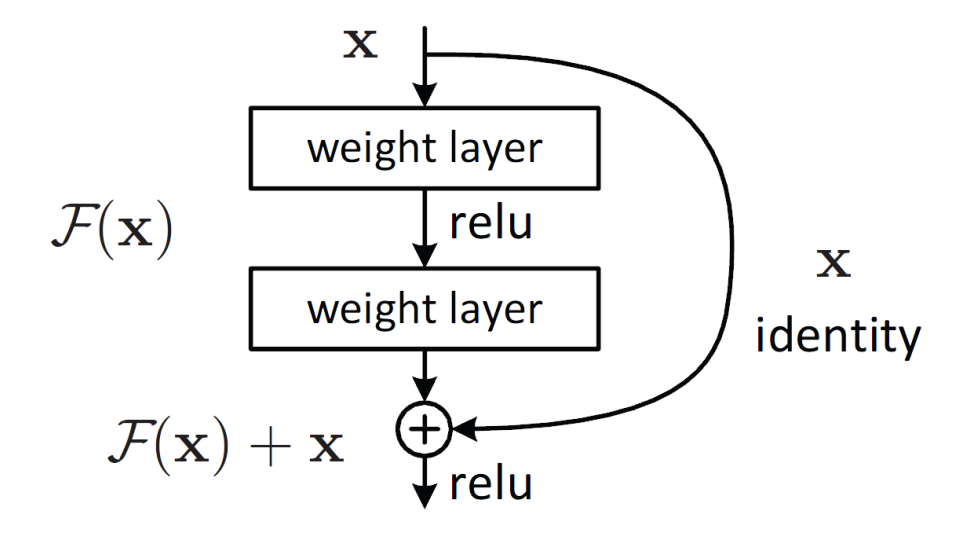

### Inception Module
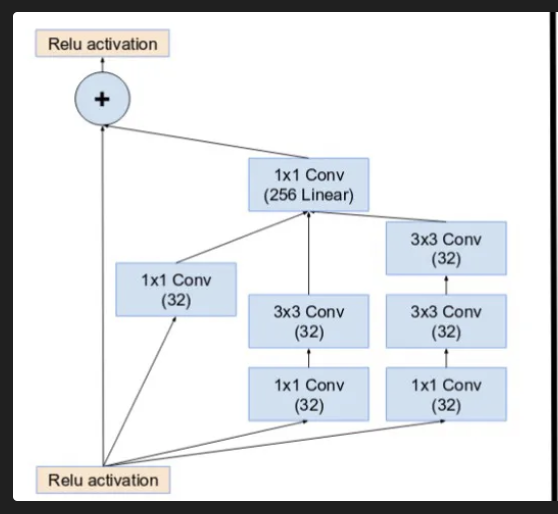
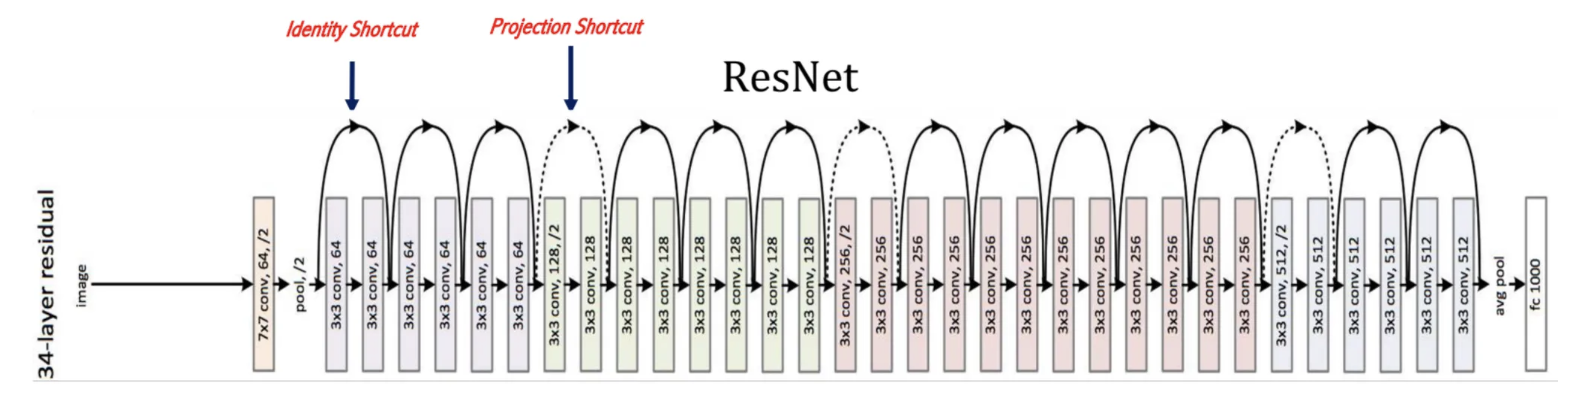

In [10]:
class Inception_Module(nn.Module):
    def __init__(self, in_channels):
        super().__init__()

        self.leakyrelu = nn.LeakyReLU(0.1)
        
        self.path_1 = nn.Sequential(
            nn.Conv2d(in_channels = in_channels, out_channels = 32, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.1)
        )
            
        self.path_2 = nn.Sequential(
            nn.Conv2d(in_channels = in_channels, out_channels = 32, kernel_size = 1, stride = 1, padding = 0),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.1),
            
            nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.1)
        )

        self.path_3 = nn.Sequential(
            nn.Conv2d(in_channels = in_channels, out_channels = 32, kernel_size = 1, stride = 1, padding = 0),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.1),
            
            nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.1),

            nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.1)
        )

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels = 32 * 3, out_channels = 256, kernel_size = 1, stride = 1, padding = 0),
            nn.BatchNorm2d(256)
        )

        if in_channels != 256:
            self.projection = nn.Sequential(
                nn.Conv2d(in_channels = in_channels, out_channels = 256, kernel_size = 1, stride = 1, padding = 0),
                nn.BatchNorm2d(256)
            )
        else:
            self.projection = nn.Sequential()

    def forward(self, X):
        X = self.leakyrelu(X)

        X_projection = self.projection(X)

        X_path_1 = self.path_1(X)

        X_path_2 = self.path_2(X)

        X_path_3 = self.path_3(X)

        X_concat = torch.cat([X_path_1, X_path_2, X_path_3], dim=1)  # dim=1 → channel dimension

        X_prefinal = self.conv(X_concat)

        X_final = X_prefinal + X_projection

        X_final = self.leakyrelu(X_final)

        return X_final

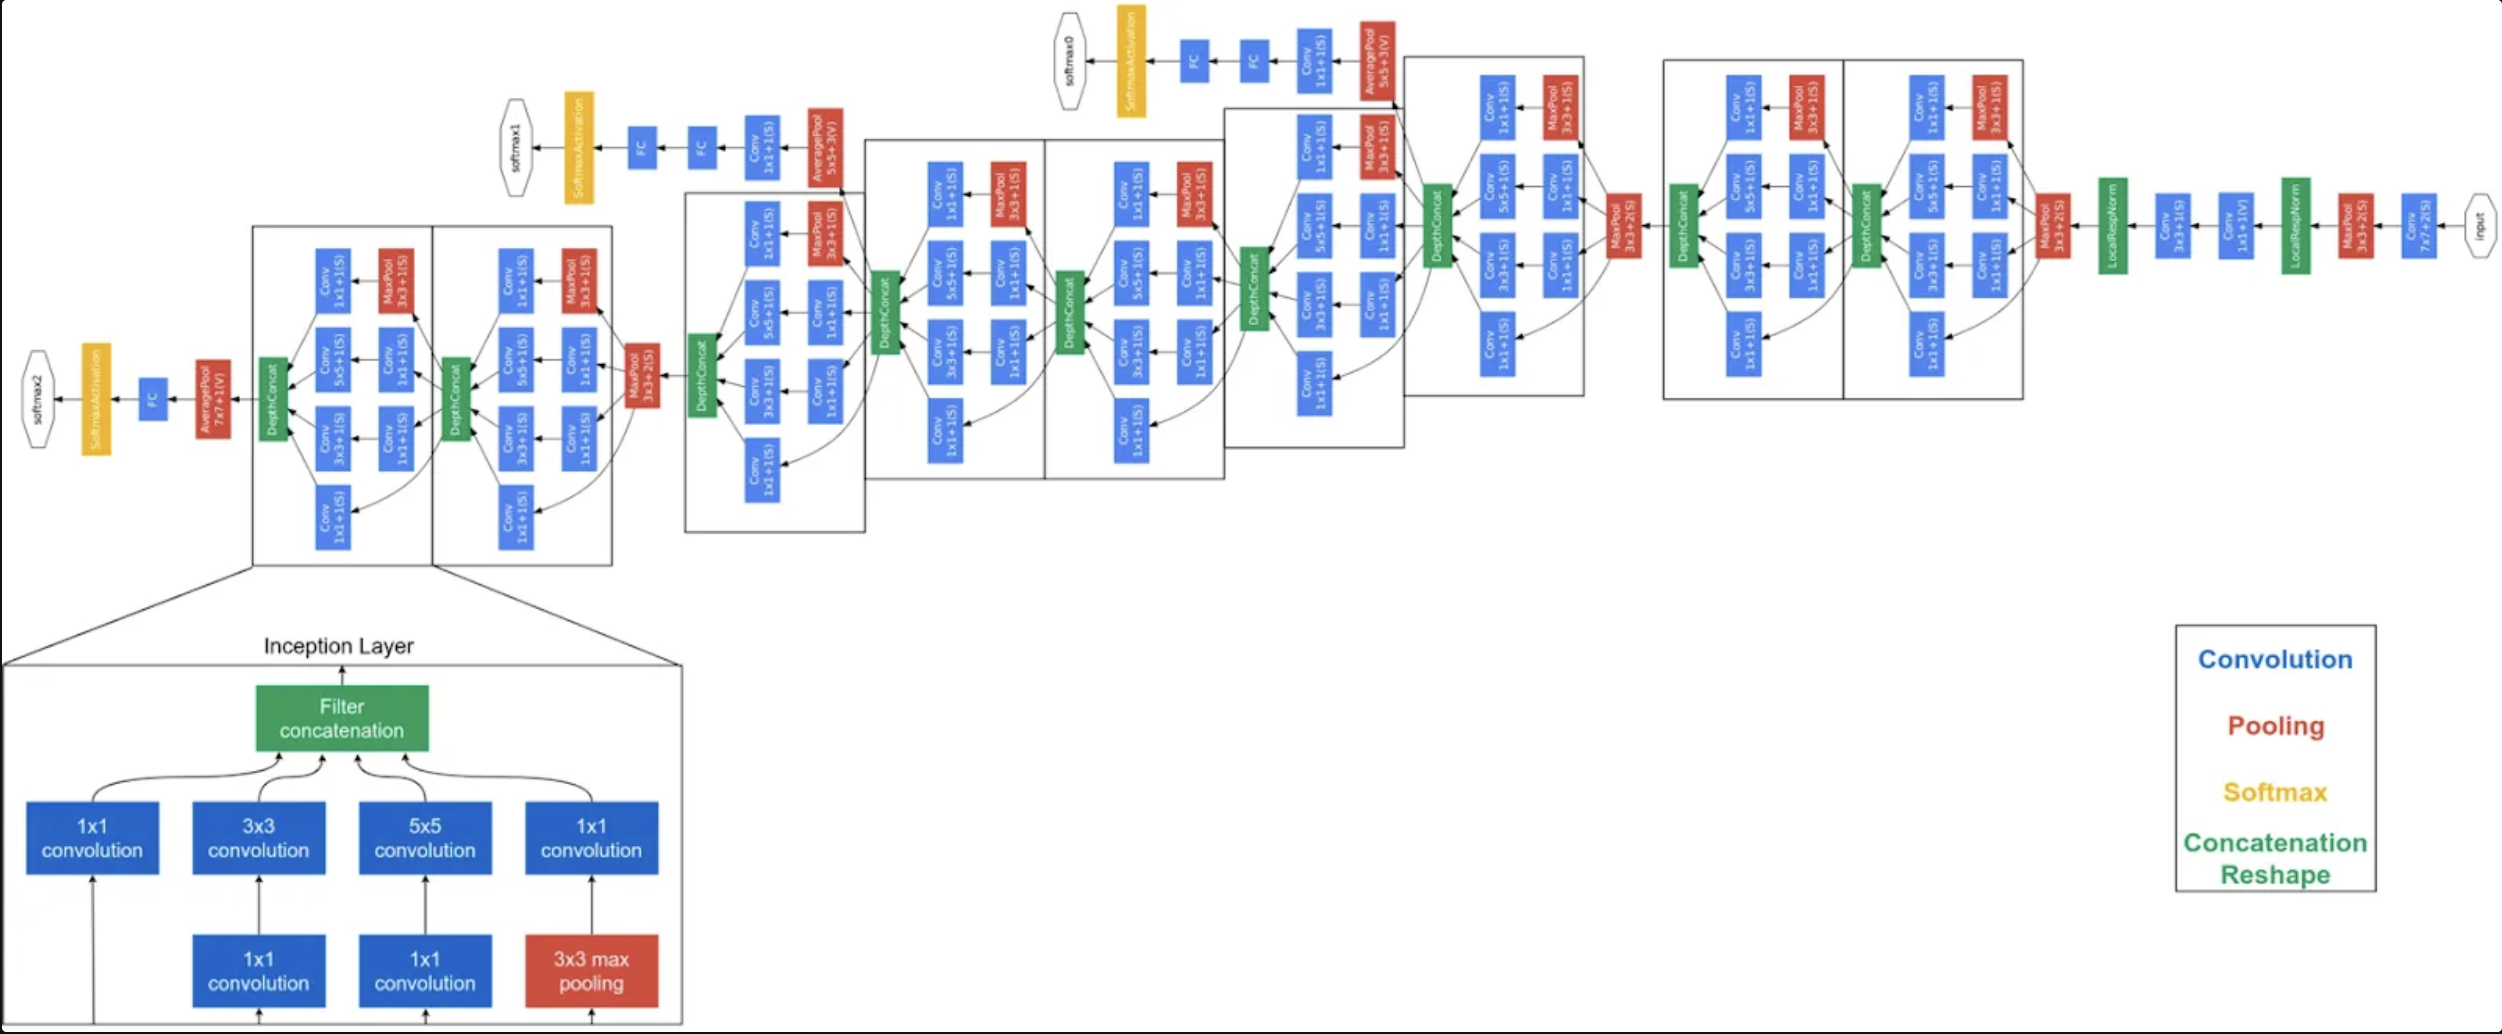

In [11]:
class Google_Lenet_V4(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = 7, stride = 2, padding = 3),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.1),
            
            nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1),
            
            #nn.BatchNorm2d(out_channels),

            nn.Conv2d(in_channels = out_channels, out_channels = out_channels, kernel_size = 1, stride = 1, padding = 0),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.1),

            nn.Conv2d(in_channels = out_channels, out_channels = out_channels, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.1),

            #nn.BatchNorm2d(out_channels),

            nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1),

            Inception_Module(out_channels),

            Inception_Module(256),

            nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1),

            Inception_Module(256),
        )

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(output_size=(1, 1)),
            nn.Conv2d(in_channels = 256, out_channels = 64, kernel_size = 1, stride = 1, padding = 0),
            nn.Flatten(),
            nn.Linear(64, 128),
            nn.Linear(128, 11)
        )

    def forward(self, X):
        X = self.feature_extractor(X)
        
        X = self.classifier(X)

        return X

# Training

In [12]:
def evaluate(model, test_dataloader, criterion, metric, device):
    model.eval()
    losses = []

    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            losses.append(loss.item())

            _, predicted = torch.max(outputs, 1)
            metric.update(predicted, labels)

    loss = sum(losses) / len(losses)
    metric_score = metric.compute().item()

    return loss, metric_score

In [19]:
def fit(
    model,
    train_loader,
    val_loader,
    criterion,
    metric,
    optimizer,
    device,
    epochs
):
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    best_state_dict = None
    best_score = 0

    model.to(device)
    for epoch in range(epochs):
        batch_train_losses = []

        model.train()
        for idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_train_losses.append(loss.item())
            
            _, predicted = torch.max(outputs, 1)
            metric.update(predicted, labels)

        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)

        train_acc = metric.compute().item()
        train_accs.append(train_acc)

        

        val_loss, val_acc = evaluate(
            model, val_loader, criterion, metric, device
        )
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(
            f"""
            EPOCH {epoch + 1}:\n
            \tTrain loss: {train_loss:.4f}\tTrain Acc: {train_acc:.4f}\n
            \tVal loss: {val_loss:.4f}\tVal Acc: {val_acc:.4f}
            """)

        if val_acc > best_score:
            best_score = val_acc
            best_model_state = model.state_dict()
            print("=====================")
            print(f"Epoch {epoch+1}: New best F1 on val = {best_score}, saving model...") 
            print("=====================")
        
    return train_losses, train_accs, val_losses, val_accs, best_model_state


In [20]:
lr = 1e-2
epochs = 25

model = Google_Lenet_V4(3, 64)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=lr
)
metric = MulticlassF1Score(num_classes=11, average='macro').to(device)

In [ ]:
results = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    metric,
    optimizer,
    device,
    epochs
)


            EPOCH 1:

            	Train loss: 1.4846	Train Acc: 0.4222

            	Val loss: 1.6567	Val Acc: 0.4245
            
Epoch 1: New best F1 on val = 0.42448896169662476, saving model...

            EPOCH 2:

            	Train loss: 1.1348	Train Acc: 0.4944

            	Val loss: 1.7802	Val Acc: 0.4904
            
Epoch 2: New best F1 on val = 0.49037235975265503, saving model...

            EPOCH 3:

            	Train loss: 1.0409	Train Acc: 0.5301

            	Val loss: 1.7107	Val Acc: 0.5268
            
Epoch 3: New best F1 on val = 0.5267688035964966, saving model...

            EPOCH 4:

            	Train loss: 0.9560	Train Acc: 0.5508

            	Val loss: 1.7187	Val Acc: 0.5462
            
Epoch 4: New best F1 on val = 0.5461668968200684, saving model...

            EPOCH 5:

            	Train loss: 0.9022	Train Acc: 0.5679

            	Val loss: 4.4890	Val Acc: 0.5624
            
Epoch 5: New best F1 on val = 0.5624082088470459, saving model...

  

In [22]:
def plot_results(Training_Loss, Training_Acc, val_Loss, val_Acc):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(Training_Loss, color="blue", label="Training Loss")
    plt.plot(val_Loss, color="green", label="val Loss")
    plt.title("Training and val Loss curves")
    plt.xlabel("Epoch")
    plt.ylabel("Loss value")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(Training_Acc, color="blue", label="Training Accuracy")
    plt.plot(val_Acc, color="green", label="val Accuracy")
    plt.title("Training and val Accuracy curves")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy value")
    plt.legend()

    plt.tight_layout()
    plt.show()

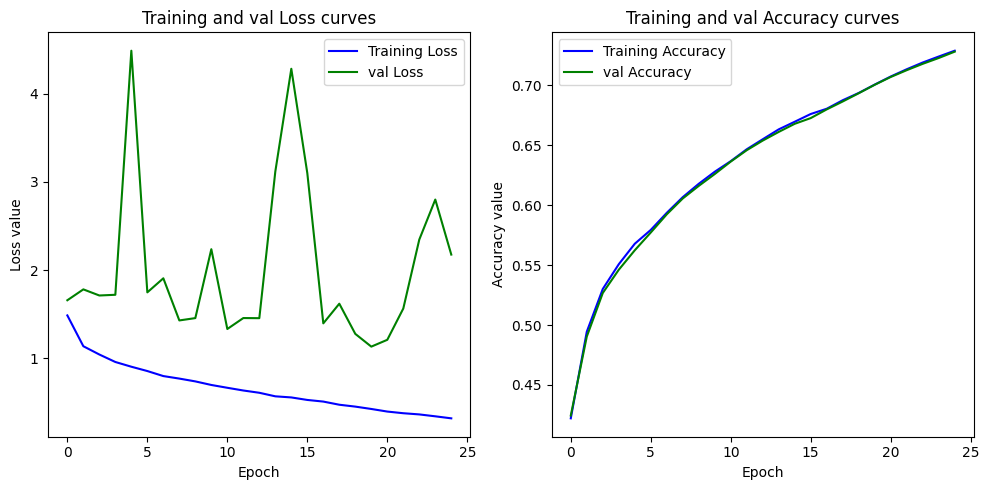

In [23]:
plot_results(results[0], results[1], results[2], results[3])

# Evaluate on Test

In [32]:
model_test = Google_Lenet_V4(3, 64)

In [33]:
model_test.load_state_dict(results[4])
test_loss, test_acc = evaluate(
    model_test.to(device), test_loader, criterion, metric, device
)

print(test_loss, test_acc)

2.0203366604718296 0.727386474609375
